#### CSC180 Project 2

#### Xiong Moua Student_id: 220278332
#### William Moosakhanian Student_id: 302537495

#### API References


#### Merging: https://pandas.pydata.org/docs/user_guide/merging.html
#### Mask: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html
#### Copy: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html
#### Head: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html
#### Value Count: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html
#### Shape: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html
#### Indexing: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
#### Boolean Indexing: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#indexing-boolean
#### Read CSV: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html 
#### Duplicates: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
#### Replace: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html

#### SVM: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm
#### Metrics: https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics
#### Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### Unique Values: https://favtutor.com/blogs/pandas-unique-values-in-column
#### List Comprehensions: https://www.w3schools.com/python/python_lists_comprehension.asp

#### ** ****IMPORTS**** **

In [1]:
from collections.abc import Sequence
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import pandas as pd
import json
import numpy as np
import sklearn.feature_extraction.text as sk_text
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import os
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report
import warnings
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import roc_curve, auc

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


start = time.time()
warnings.filterwarnings('ignore')

In [3]:
train_excel = pd.read_csv('UNSW_NB15_training-set.csv')
test_excel = pd.read_csv('UNSW_NB15_test-set.csv')

print(train_excel)

            id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0            1  0.121478   tcp       -   FIN      6      4     258     172   
1            2  0.649902   tcp       -   FIN     14     38     734   42014   
2            3  1.623129   tcp       -   FIN      8     16     364   13186   
3            4  1.681642   tcp     ftp   FIN     12     12     628     770   
4            5  0.449454   tcp       -   FIN     10      6     534     268   
...        ...       ...   ...     ...   ...    ...    ...     ...     ...   
175336  175337  0.000009   udp     dns   INT      2      0     114       0   
175337  175338  0.505762   tcp       -   FIN     10      8     620     354   
175338  175339  0.000009   udp     dns   INT      2      0     114       0   
175339  175340  0.000009   udp     dns   INT      2      0     114       0   
175340  175341  0.000009   udp     dns   INT      2      0     114       0   

                 rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  i

In [4]:
train_df = train_excel
test_df = test_excel
train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
unique_vals_train = (train_df['proto'].append(train_df['service'].append(train_df['state'].append(train_df['attack_cat'])))).unique()
unique_vals_train.sort()

unique_vals_test = (test_df['proto'].append(test_df['service'].append(test_df['state'].append(test_df['attack_cat'])))).unique()
unique_vals_test.sort()


print(unique_vals_train)

['-' '3pc' 'Analysis' 'Backdoor' 'CON' 'DoS' 'ECO' 'Exploits' 'FIN'
 'Fuzzers' 'Generic' 'INT' 'Normal' 'PAR' 'REQ' 'RST' 'Reconnaissance'
 'Shellcode' 'URN' 'Worms' 'a/n' 'aes-sp3-d' 'any' 'argus' 'aris' 'arp'
 'ax.25' 'bbn-rcc' 'bna' 'br-sat-mon' 'cbt' 'cftp' 'chaos' 'compaq-peer'
 'cphb' 'cpnx' 'crtp' 'crudp' 'dcn' 'ddp' 'ddx' 'dgp' 'dhcp' 'dns' 'egp'
 'eigrp' 'emcon' 'encap' 'etherip' 'fc' 'fire' 'ftp' 'ftp-data' 'ggp'
 'gmtp' 'gre' 'hmp' 'http' 'i-nlsp' 'iatp' 'ib' 'icmp' 'idpr' 'idpr-cmtp'
 'idrp' 'ifmp' 'igmp' 'igp' 'il' 'ip' 'ipcomp' 'ipcv' 'ipip' 'iplt'
 'ipnip' 'ippc' 'ipv6' 'ipv6-frag' 'ipv6-no' 'ipv6-opts' 'ipv6-route'
 'ipx-n-ip' 'irc' 'irtp' 'isis' 'iso-ip' 'iso-tp4' 'kryptolan' 'l2tp'
 'larp' 'leaf-1' 'leaf-2' 'merit-inp' 'mfe-nsp' 'mhrp' 'micp' 'mobile'
 'mtp' 'mux' 'narp' 'netblt' 'no' 'nsfnet-igp' 'nvp' 'ospf' 'pgm' 'pim'
 'pipe' 'pnni' 'pop3' 'pri-enc' 'prm' 'ptp' 'pup' 'pvp' 'qnx' 'radius'
 'rdp' 'rsvp' 'rtp' 'rvd' 'sat-expak' 'sat-mon' 'sccopmce' 'scps' 'sctp'
 'sd

In [6]:
print(unique_vals_test.size)
print(unique_vals_train.size)

161
165


In [7]:
not_inside = []
test_length = len(unique_vals_test) - 1
for i in range(len(unique_vals_train)):
    temp_val = unique_vals_train[i]
    for j in range(len(unique_vals_test)):
        
        if temp_val == unique_vals_test[j]:
            #print(str(i) + " " + str(j) + " " + temp_val)
            break
            
        elif temp_val != unique_vals_test[j]:
            #print(str(i) + " " + str(j) + " " + temp_val + " not inside" )
            if j == test_length:
                not_inside.append(temp_val)
                #print("appended")
            continue
        else:
            print("error")
            
train_length = len(unique_vals_train) - 1
for i in range(len(unique_vals_test)):
    temp_val = unique_vals_test[i]
    for j in range(len(unique_vals_train)):
        
        if temp_val == unique_vals_train[j]:
            #print(str(i) + " " + str(j) + " " + temp_val)
            break
            
        elif temp_val != unique_vals_train[j]:
            #print(str(i) + " " + str(j) + " " + temp_val + " not inside" )
            if j == train_length:
                not_inside.append(temp_val)
                #print("appended")
            continue
        else:
            print("error") 
not_inside.sort()
print(not_inside)

['ACC', 'CLO', 'ECO', 'PAR', 'URN', 'icmp', 'no', 'rtp']


In [8]:
cols = ['proto', 'service', 'state', 'attack_cat']

filtered_train_df = train_df
filtered_test_df = test_df

index_train_list = []
index_test_list = []

for i in range(len(cols)):
    # print(not_inside[i])\
    # print(cols[i])
    for j in range(len(not_inside)):
        # print(not_inside[j])
        flt_train = filtered_train_df[filtered_train_df[cols[i]] == not_inside[j]].index.values
        flt_test = filtered_test_df[filtered_test_df[cols[i]] == not_inside[j]].index.values
        if flt_train.size != 0:
            # print(flt)
            index_train_list.extend(flt_train)
        if flt_test.size != 0:
            index_test_list.extend(flt_test)


index_train_list = list(set(index_train_list))
index_test_list = list(set(index_test_list))

index_train_list.sort()
index_test_list.sort()

print("TRAIN: " + str(index_train_list))
print("TEST: " + str(index_test_list))

TRAIN: [141, 2833, 5611, 6827, 13249, 16466, 18578, 18916, 20806, 20808, 23251, 23366, 27500, 29457, 32911, 39937]
TEST: [458, 25532, 25772, 49080, 56546]


In [9]:
filtered_train_df = filtered_train_df.drop(filtered_train_df.index[index_train_list])
filtered_test_df = filtered_test_df.drop(filtered_test_df.index[index_test_list])


In [10]:
print(len(filtered_test_df))
print(len(test_df))

print(len(filtered_train_df))
print(len(train_df))

82327
82332
175325
175341


In [11]:
col_names = list(filtered_train_df.columns.values)
cols_remove = ['id', 'proto', 'service', 'state', 'attack_cat', 'label', 'is_ftp_login', 'is_sm_ips_ports', 'trans_depth']
remove_cols = [x for x in col_names if x not in cols_remove]

print(remove_cols)

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst']


In [12]:
new_train_df = pd.DataFrame(filtered_train_df['label'].apply(lambda x: 'Normal' if x == 0 else 'Attack'))
new_train_df.rename(columns={'label': 'label_check'}, inplace=True)

new_test_df = pd.DataFrame(filtered_test_df['label'].apply(lambda x: 'Normal' if x == 0 else 'Attack'))
new_test_df.rename(columns={'label': 'label_check'}, inplace=True)

new_test_df.head()

,label_check
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal


In [13]:
combined_train_df = pd.concat([filtered_train_df, new_train_df], axis=1)
combined_test_df = pd.concat([filtered_test_df, new_test_df], axis=1)

In [14]:
combined_train_df.shape

(175325, 46)

In [15]:
for i in range(len(remove_cols)):
    encode_numeric_zscore(combined_train_df, remove_cols[i])
    encode_numeric_zscore(combined_test_df, remove_cols[i])
    
cols_temp = ['proto', 'state', 'service', 'attack_cat']

for i in range(len(cols_temp)):
    encode_text_dummy(combined_train_df, cols_temp[i])
    encode_text_dummy(combined_test_df, cols_temp[i])

In [16]:
filtered_train_copy = combined_train_df

filtered_test_copy = combined_test_df
filtered_test_copy.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,attack_cat-Analysis,attack_cat-Backdoor,attack_cat-DoS,attack_cat-Exploits,attack_cat-Fuzzers,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Shellcode,attack_cat-Worms
0,1,-0.213729,-0.124458,-0.151819,-0.043685,-0.087371,0.057147,0.71943,-0.82036,0.643870,...,0,0,0,0,0,0,1,0,0,0
1,2,-0.213729,-0.124458,-0.151819,-0.036309,-0.087371,0.286524,0.71943,-0.82036,4.539181,...,0,0,0,0,0,0,1,0,0,0
2,3,-0.213730,-0.124458,-0.151819,-0.040352,-0.087371,0.791155,0.71943,-0.82036,4.391294,...,0,0,0,0,0,0,1,0,0,0
3,4,-0.213730,-0.124458,-0.151819,-0.041331,-0.087371,0.566874,0.71943,-0.82036,2.976912,...,0,0,0,0,0,0,1,0,0,0
4,5,-0.213729,-0.124458,-0.151819,-0.034189,-0.087371,0.118314,0.71943,-0.82036,4.369055,...,0,0,0,0,0,0,1,0,0,0


In [17]:
filtered_test_copy.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,attack_cat-Analysis,attack_cat-Backdoor,attack_cat-DoS,attack_cat-Exploits,attack_cat-Fuzzers,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Shellcode,attack_cat-Worms
0,1,-0.213729,-0.124458,-0.151819,-0.043685,-0.087371,0.057147,0.71943,-0.82036,0.643870,...,0,0,0,0,0,0,1,0,0,0
1,2,-0.213729,-0.124458,-0.151819,-0.036309,-0.087371,0.286524,0.71943,-0.82036,4.539181,...,0,0,0,0,0,0,1,0,0,0
2,3,-0.213730,-0.124458,-0.151819,-0.040352,-0.087371,0.791155,0.71943,-0.82036,4.391294,...,0,0,0,0,0,0,1,0,0,0
3,4,-0.213730,-0.124458,-0.151819,-0.041331,-0.087371,0.566874,0.71943,-0.82036,2.976912,...,0,0,0,0,0,0,1,0,0,0
4,5,-0.213729,-0.124458,-0.151819,-0.034189,-0.087371,0.118314,0.71943,-0.82036,4.369055,...,0,0,0,0,0,0,1,0,0,0


In [18]:
print(filtered_train_copy.shape)
print(filtered_test_copy.shape)

(175325, 201)
(82327, 201)


In [19]:
filtered_train_copy = filtered_train_copy.drop('id', axis=1)
filtered_test_copy = filtered_test_copy.drop('id', axis=1)

filtered_test_copy.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat-Analysis,attack_cat-Backdoor,attack_cat-DoS,attack_cat-Exploits,attack_cat-Fuzzers,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Shellcode,attack_cat-Worms
0,-0.213729,-0.124458,-0.151819,-0.043685,-0.087371,0.057147,0.71943,-0.82036,0.643870,-0.2635,...,0,0,0,0,0,0,1,0,0,0
1,-0.213729,-0.124458,-0.151819,-0.036309,-0.087371,0.286524,0.71943,-0.82036,4.539181,-0.2635,...,0,0,0,0,0,0,1,0,0,0
2,-0.213730,-0.124458,-0.151819,-0.040352,-0.087371,0.791155,0.71943,-0.82036,4.391294,-0.2635,...,0,0,0,0,0,0,1,0,0,0
3,-0.213730,-0.124458,-0.151819,-0.041331,-0.087371,0.566874,0.71943,-0.82036,2.976912,-0.2635,...,0,0,0,0,0,0,1,0,0,0
4,-0.213729,-0.124458,-0.151819,-0.034189,-0.087371,0.118314,0.71943,-0.82036,4.369055,-0.2635,...,0,0,0,0,0,0,1,0,0,0


In [20]:
attack_cat1 = encode_text_index(filtered_train_copy, 'label_check')
attack_cat2 = encode_text_index(filtered_test_copy, 'label_check')

In [21]:
x_train, y_train = to_xy(filtered_train_copy,'label_check')
x_test, y_test = to_xy(filtered_test_copy, 'label_check')

In [22]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(175325, 199)
(175325, 2)
(82327, 199)
(82327, 2)


In [23]:
print(y_train)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [24]:
print(attack_cat2)

['Attack' 'Normal']


#### **Logistic Regression Model**

In [25]:
log_reg_copy_train = filtered_train_copy
log_reg_copy_test = filtered_test_copy

log_reg_copy_test.shape

(82327, 200)

In [26]:
label_encoder = LabelEncoder()
log_reg_copy_train['label_checks'] = label_encoder.fit_transform(log_reg_copy_train['label_check'])
log_reg_copy_test['label_checks'] = label_encoder.fit_transform(log_reg_copy_test['label_check'])
log_reg_copy_test.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat-Backdoor,attack_cat-DoS,attack_cat-Exploits,attack_cat-Fuzzers,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Shellcode,attack_cat-Worms,label_checks
0,-0.213729,-0.124458,-0.151819,-0.043685,-0.087371,0.057147,0.71943,-0.82036,0.643870,-0.2635,...,0,0,0,0,0,1,0,0,0,1
1,-0.213729,-0.124458,-0.151819,-0.036309,-0.087371,0.286524,0.71943,-0.82036,4.539181,-0.2635,...,0,0,0,0,0,1,0,0,0,1
2,-0.213730,-0.124458,-0.151819,-0.040352,-0.087371,0.791155,0.71943,-0.82036,4.391294,-0.2635,...,0,0,0,0,0,1,0,0,0,1
3,-0.213730,-0.124458,-0.151819,-0.041331,-0.087371,0.566874,0.71943,-0.82036,2.976912,-0.2635,...,0,0,0,0,0,1,0,0,0,1
4,-0.213729,-0.124458,-0.151819,-0.034189,-0.087371,0.118314,0.71943,-0.82036,4.369055,-0.2635,...,0,0,0,0,0,1,0,0,0,1


In [27]:
log_reg_copy_train['label_checks'] = log_reg_copy_train['label_checks'].replace(0,2)
log_reg_copy_train['label_checks'] = log_reg_copy_train['label_checks'].replace(1,0)
log_reg_copy_train['label_checks'] = log_reg_copy_train['label_checks'].replace(2,1)

log_reg_copy_test['label_checks'] = log_reg_copy_test['label_checks'].replace(0,2)
log_reg_copy_test['label_checks'] = log_reg_copy_test['label_checks'].replace(1,0)
log_reg_copy_test['label_checks'] = log_reg_copy_test['label_checks'].replace(2,1)

In [28]:
# log_reg_copy_train.to_csv('tesasdf.csv', sep=',', index=False)

In [29]:
log_y_train = log_reg_copy_train['label_checks'].values
log_y_test = log_reg_copy_test['label_checks'].values

In [30]:
print(log_y_train)
print(log_y_test)

[0 0 0 ... 1 1 1]
[0 0 0 ... 0 0 0]


In [31]:
print(log_y_train.shape)
print(log_y_test.shape)

(175325,)
(82327,)


In [32]:
logreg = LogisticRegression(solver='lbfgs', multi_class='ovr')
logreg.fit(x_train, log_y_train)
logreg.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [33]:
log_pred = logreg.predict(x_test)
score = metrics.accuracy_score(log_y_test, log_pred)
print("Final accuracy: {}".format(score))

Final accuracy: 1.0


[[36998     0]
 [    0 45329]]


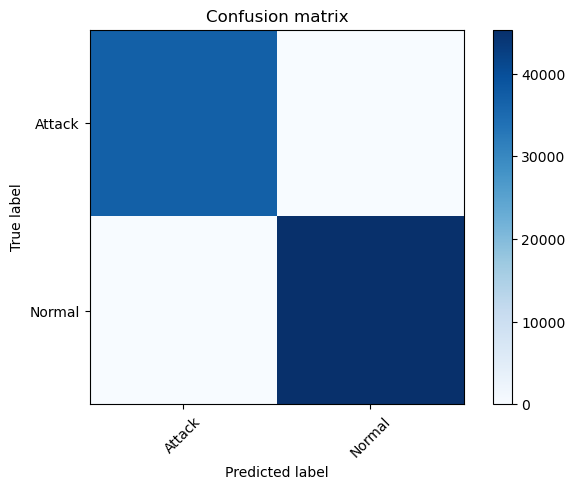

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36998
           1       1.00      1.00      1.00     45329

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [34]:
logistic_matrix = confusion_matrix (log_y_test, log_pred)
print(logistic_matrix)
plt.figure()
plot_confusion_matrix(logistic_matrix, attack_cat2)
plt.show()
print(classification_report(log_y_test, log_pred))

In [35]:
# log_pred = logreg.predict(x_test)
# log_pred = log_pred[:,1] # Only positive class (M)
# plot_roc(log_pred,y_true)

#### **Support Vector Machine Model**

In [36]:
# svc_class = svm.SVC(decision_function_shape='ovo')
# svc_class.fit(x_train, log_y_train)
# svm_pred = svc_class.pred(x_test)


#### **Fully-Connected Neural Networks Model**

In [37]:
combinations = [
    ('relu', 'adam'),
    ('sigmoid', 'adam'),
    ('tanh', 'adam'),
    ('relu', 'sgd'),
    ('sigmoid', 'sgd'),
    ('tanh', 'sgd')
]



checkpoints = {
    
}

checkpoints_cnn = {
    
}


filepath = "dnn/best_weights_"
for i in range(2):
    
    if i == 0:
        for j in range(len(combinations)):
            # print(j)
            model = combinations[j]
            if model == ('relu', 'adam'):
                checkpoints[model] = filepath + 'fnn_rluadam.hdf5'
            if model == ('sigmoid', 'adam'):
                checkpoints[model] = filepath + 'fnn_sigadam.hdf5'
            if model == ('tanh', 'adam'):
                checkpoints[model] = filepath + 'fnn_tanhadam.hdf5'
            if model == ('relu', 'sgd'):
                checkpoints[model] = filepath + 'fnn_rluasgd.hdf5'
            if model == ('sigmoid', 'sgd'):
                checkpoints[model] = filepath + 'fnn_sigsgd.hdf5'
            if model == ('tanh', 'sgd'):
                checkpoints[model] = filepath + 'fnn_tanhsgd.hdf5'
    if i == 1:
        for k in range(len(combinations)):
            # print(k)
            model = combinations[k]
            if model == ('relu', 'adam'):
                checkpoints_cnn[model] = filepath + 'cnn_rluadam.hdf5'
            if model == ('sigmoid', 'adam'):
                checkpoints_cnn[model] = filepath + 'cnn_sigadam.hdf5'
            if model == ('tanh', 'adam'):
                checkpoints_cnn[model] = filepath + 'cnn_tanhadam.hdf5'
            if model == ('relu', 'sgd'):
                checkpoints_cnn[model] = filepath + 'cnn_rluasgd.hdf5'
            if model == ('sigmoid', 'sgd'):
                checkpoints_cnn[model] = filepath + 'cnn_sigsgd.hdf5'
            if model == ('tanh', 'sgd'):
                checkpoints_cnn[model] =filepath + 'cnn_tanhsgd.hdf5'
        
print(checkpoints_cnn)

{('relu', 'adam'): 'dnn/best_weights_cnn_rluadam.hdf5', ('sigmoid', 'adam'): 'dnn/best_weights_cnn_sigadam.hdf5', ('tanh', 'adam'): 'dnn/best_weights_cnn_tanhadam.hdf5', ('relu', 'sgd'): 'dnn/best_weights_cnn_rluasgd.hdf5', ('sigmoid', 'sgd'): 'dnn/best_weights_cnn_sigsgd.hdf5', ('tanh', 'sgd'): 'dnn/best_weights_cnn_tanhsgd.hdf5'}


In [38]:
neuron_count = x_train.shape[1]
div = 3
print(neuron_count)

result_values = [

]

199


In [39]:
for i in range(len(combinations)):
    model_comp = combinations[i]
    print(model_comp)
    checkpointer = ModelCheckpoint(filepath=checkpoints[model_comp], verbose=0, save_best_only=True)
    print(checkpoints[model_comp])
    model = Sequential()
    for j in range(1):
        
        model.add(Dense(neuron_count, input_dim=x_train.shape[1],activation=model_comp[0]))
        model.add(Dense(neuron_count/div, activation=model_comp[0]))
        model.add(Dense(neuron_count/(div*2), activation=model_comp[0]))
        model.add(Dense(y_train.shape[1], activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))
        
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
        model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=1,epochs=1000)
    model.load_weights(checkpoints[model_comp])
    pred = model.predict(x_test)
    pred = np.argmax(pred,axis=1)
    
    y_true = np.argmax(y_test,axis=1)
    score = metrics.accuracy_score(y_true,pred)
    cm = confusion_matrix(y_true, pred)
    
    
    result = (model_comp, pred, y_true, score, cm)
    
    result_values.append(result)
    
    

('relu', 'adam')
dnn/best_weights_fnn_rluadam.hdf5
Epoch 1/1000
5479/5479 [==============================] - 19s 3ms/step - loss: 0.0039 - val_loss: 2.6278e-04
Epoch 2/1000
5479/5479 [==============================] - 20s 4ms/step - loss: 5.3151e-04 - val_loss: 1.5219e-04
Epoch 3/1000
5479/5479 [==============================] - 22s 4ms/step - loss: 5.7335e-04 - val_loss: 1.2901e-04
Epoch 3: early stopping
2573/2573 [==============================] - 3s 1ms/step
('sigmoid', 'adam')
dnn/best_weights_fnn_sigadam.hdf5
Epoch 1/1000
5479/5479 [==============================] - 22s 4ms/step - loss: 0.0116 - val_loss: 1.2496e-04
Epoch 2/1000
5479/5479 [==============================] - 21s 4ms/step - loss: 3.4513e-04 - val_loss: 1.3472e-04
Epoch 3/1000
5479/5479 [==============================] - 20s 4ms/step - loss: 1.5556e-04 - val_loss: 0.0295
Epoch 3: early stopping
2573/2573 [==============================] - 3s 1ms/step
('tanh', 'adam')
dnn/best_weights_fnn_tanhadam.hdf5
Epoch 1/1000
54

#### **FNN RELU_ADAM MODEL**

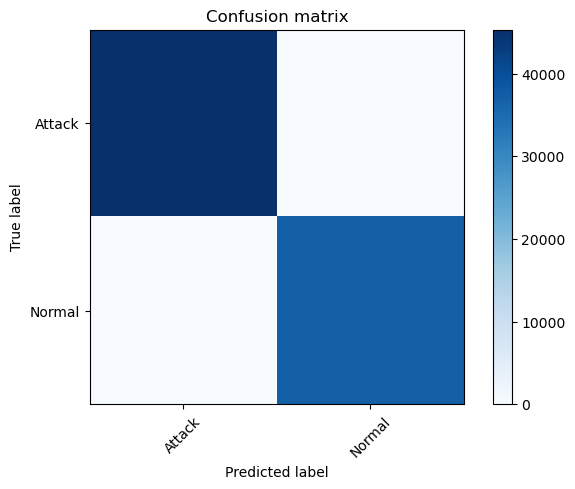

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [40]:
relu_adam = result_values[0]
relu_adam_pred = relu_adam[1]
relu_adam_y_true = relu_adam[2]

relu_adam_score = relu_adam[3]
relu_adam_cm = relu_adam[4]

plt.figure()
plot_confusion_matrix(relu_adam_cm, attack_cat2)
plt.show()
print(classification_report(relu_adam_y_true,relu_adam_pred))

In [41]:
# relu_adam_pred = relu_adam_pred[:,1] # Only positive class (M)
# plot_roc(relu_adam_pred,)

#### **FNN SIGMOID ADAM MODEL**

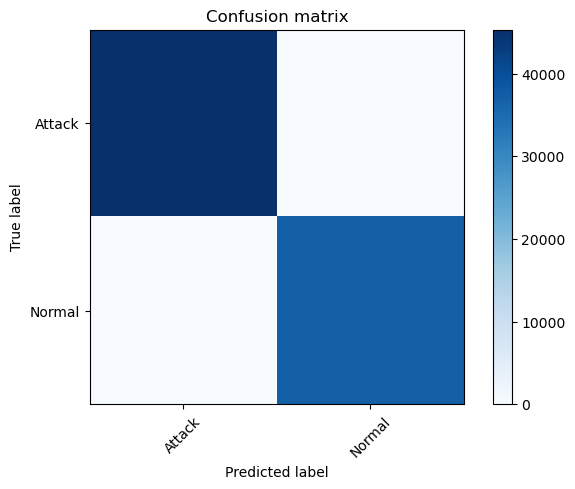

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [42]:
sig_adam = result_values[1]
sig_adam_pred = sig_adam[1]
sig_adam_y_true = sig_adam[2]
sig_adam_score = sig_adam[3]
sig_adam_cm = sig_adam[4]

plt.figure()
plot_confusion_matrix(sig_adam_cm, attack_cat2)
plt.show()
print(classification_report(sig_adam_y_true,sig_adam_pred))

#### **FNN TANH ADAM MODEL**

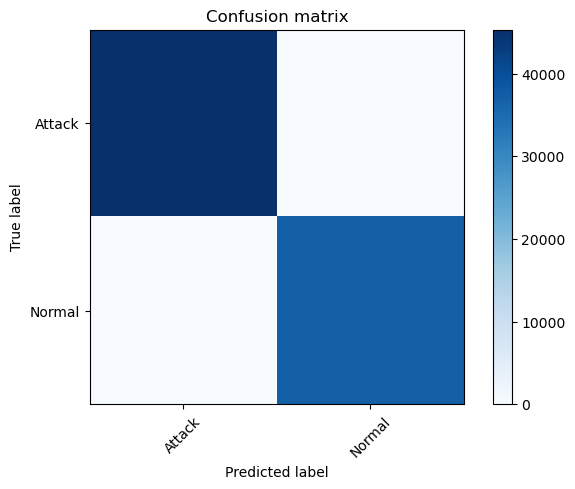

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [43]:
tanh_adam = result_values[2]
tanh_adam_pred = tanh_adam[1]
tanh_adam_y_true = tanh_adam[2]
tanh_adam_score = tanh_adam[3]
tanh_adam_cm = tanh_adam[4]

plt.figure()
plot_confusion_matrix(tanh_adam_cm, attack_cat2)
plt.show()
print(classification_report(tanh_adam_y_true,tanh_adam_pred))

#### **FNN RELU SGD MODEL**

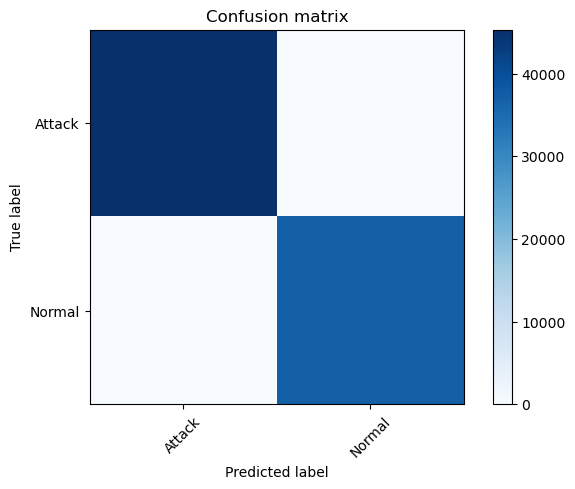

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [44]:
relu_sgd = result_values[3]
relu_sgd_pred = relu_sgd[1]
relu_sgd_y_true = relu_sgd[2]
relu_sgd_score = relu_sgd[3]
relu_sgd_cm = relu_sgd[4]

plt.figure()
plot_confusion_matrix(relu_sgd_cm, attack_cat2)
plt.show()
print(classification_report(relu_sgd_y_true,relu_sgd_pred))

#### **FNN SIGMOID SGD MODEL**

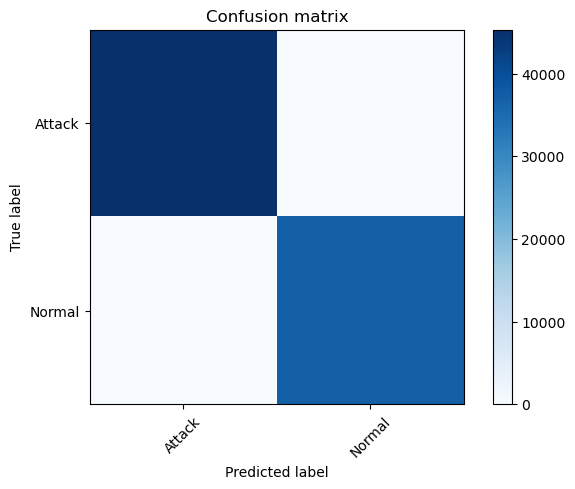

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [45]:
sig_sgd = result_values[4]
sig_sgd_pred = sig_sgd[1]
sig_sgd_y_true = sig_sgd[2]
sig_sgd_score = sig_sgd[3]
sig_sgd_cm = sig_sgd[4]

plt.figure()
plot_confusion_matrix(sig_sgd_cm, attack_cat2)
plt.show()
print(classification_report(sig_sgd_y_true,sig_sgd_pred))

#### **FNN TANH SGD MODEL**

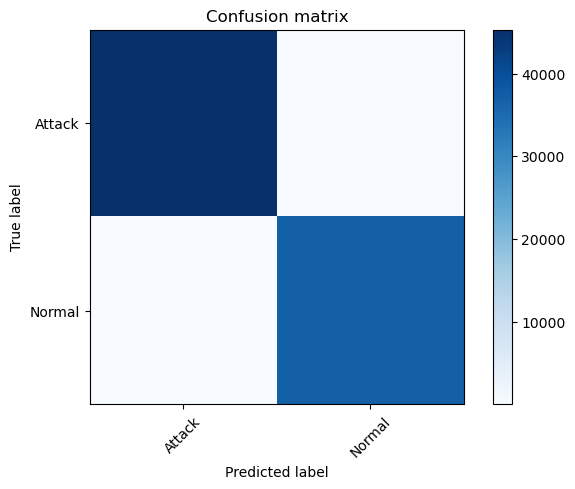

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [46]:
tanh_sgd = result_values[5]
tanh_sgd_pred = tanh_sgd[1]
tanh_sgd_y_true = tanh_sgd[2]
tanh_sgd_score = tanh_sgd[3]
tanh_sgd_cm = tanh_sgd[4]

plt.figure()
plot_confusion_matrix(tanh_sgd_cm, attack_cat2)
plt.show()
print(classification_report(tanh_sgd_y_true,tanh_sgd_pred))

#### **CNN MODEL RELU AND ADAM**

In [47]:
num_classes = 10
cnn_x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], 1))
cnn_x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], 1))
num_features=x_train.shape[1]
cnn_y_true = np.argmax(y_test,axis=1)
cnn_scores = []
batch_size = 32

In [48]:
checkpointer_cnn = ModelCheckpoint(filepath="dnn/best_weights_cnn_reluadam.hdf5", verbose=1, save_best_only=True)
cnn = Sequential()
cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 199, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

cnn.fit(cnn_x_train, y_train,     
          batch_size=batch_size,
          epochs=1000,
          verbose=1,
          validation_data=(cnn_x_test, y_test),
          callbacks=[monitor, checkpointer_cnn]
         )

Epoch 1/1000
5479/5479 [==============================] - ETA: 0s - loss: 0.0063
Epoch 1: val_loss improved from inf to 0.00025, saving model to dnn\best_weights_cnn_reluadam.hdf5
5479/5479 [==============================] - 26s 4ms/step - loss: 0.0063 - val_loss: 2.5192e-04
Epoch 2/1000
5478/5479 [============================>.] - ETA: 0s - loss: 2.3668e-04
Epoch 2: val_loss improved from 0.00025 to 0.00000, saving model to dnn\best_weights_cnn_reluadam.hdf5
5479/5479 [==============================] - 22s 4ms/step - loss: 2.3664e-04 - val_loss: 1.4205e-08
Epoch 3/1000
5479/5479 [==============================] - ETA: 0s - loss: 7.8442e-05
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to dnn\best_weights_cnn_reluadam.hdf5
5479/5479 [==============================] - 23s 4ms/step - loss: 7.8442e-05 - val_loss: 1.3321e-09
Epoch 3: early stopping


2573/2573 [==============================] - 3s 1ms/step
Accuracy: 1.0


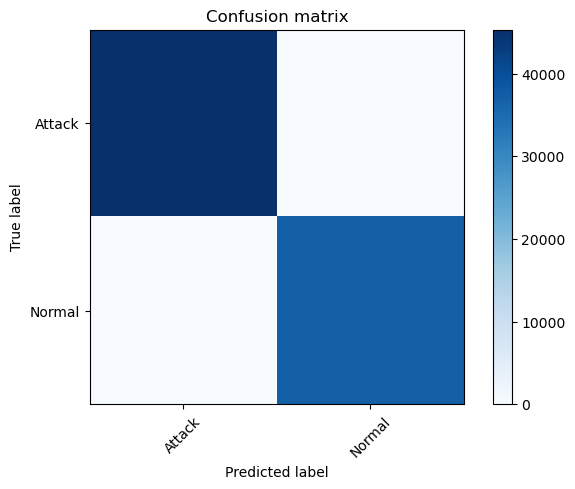

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [49]:
cnn.load_weights('dnn/best_weights_cnn_reluadam.hdf5')

pred = cnn.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(cnn_y_true, pred)
print('Accuracy: {}'.format(score))

cnn_cm = confusion_matrix(cnn_y_true, pred)
cnn_scores.append( ('reluadam', score))
plt.figure()
plot_confusion_matrix(cnn_cm, attack_cat2)
plt.show()
print(classification_report(cnn_y_true,pred))

2573/2573 [==============================] - 3s 1ms/step


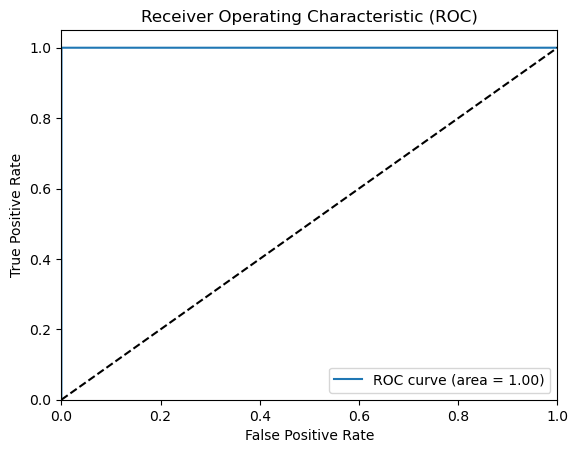

In [50]:
pred = model.predict(x_test)
pred = pred[:,1]
plot_roc(pred,y_true)

#### CNN **SIGMOID ADAM MODEL**

In [51]:
checkpointer_cnn = ModelCheckpoint(filepath="dnn/best_weights_cnn_sigmoidadam.hdf5", verbose=1, save_best_only=True)
cnn = Sequential()
cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1),
                 activation='sigmoid',
                 input_shape=(1, 199, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                 activation='sigmoid'))
cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation="sigmoid"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

cnn.fit(cnn_x_train, y_train,     
          batch_size=batch_size,
          epochs=1000,
          verbose=1,
          validation_data=(cnn_x_test, y_test),
          callbacks=[monitor, checkpointer_cnn]
         )


Epoch 1/1000
5467/5479 [============================>.] - ETA: 0s - loss: 0.0717
Epoch 1: val_loss improved from inf to 0.00003, saving model to dnn\best_weights_cnn_sigmoidadam.hdf5
5479/5479 [==============================] - 24s 4ms/step - loss: 0.0715 - val_loss: 2.9660e-05
Epoch 2/1000
5473/5479 [============================>.] - ETA: 0s - loss: 9.6647e-05
Epoch 2: val_loss improved from 0.00003 to 0.00000, saving model to dnn\best_weights_cnn_sigmoidadam.hdf5
5479/5479 [==============================] - 25s 5ms/step - loss: 9.6551e-05 - val_loss: 3.2773e-07
Epoch 3/1000
5467/5479 [============================>.] - ETA: 0s - loss: 6.0559e-05
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to dnn\best_weights_cnn_sigmoidadam.hdf5
5479/5479 [==============================] - 22s 4ms/step - loss: 6.0431e-05 - val_loss: 2.6571e-08
Epoch 3: early stopping


2573/2573 [==============================] - 3s 1ms/step
Accuracy: 1.0


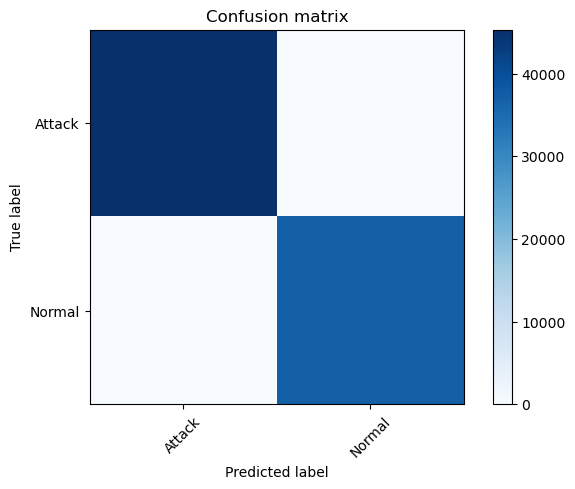

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [52]:
cnn.load_weights('dnn/best_weights_cnn_sigmoidadam.hdf5')

pred = cnn.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(cnn_y_true, pred)
print('Accuracy: {}'.format(score))

cnn_cm = confusion_matrix(cnn_y_true, pred)

plt.figure()
plot_confusion_matrix(cnn_cm, attack_cat2)
plt.show()
print(classification_report(cnn_y_true,pred))

#### **CNN TANH ADAM MODEL**

In [53]:
checkpointer_cnn = ModelCheckpoint(filepath="dnn/best_weights_cnn_tanhdadam.hdf5", verbose=1, save_best_only=True)
cnn = Sequential()
cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, 199, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                 activation='tanh'))
cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation="tanh"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

cnn.fit(cnn_x_train, y_train,     
          batch_size=batch_size,
          epochs=1000,
          verbose=1,
          validation_data=(cnn_x_test, y_test),
          callbacks=[monitor, checkpointer_cnn]
         )



Epoch 1/1000
5477/5479 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 1: val_loss improved from inf to 0.00000, saving model to dnn\best_weights_cnn_tanhdadam.hdf5
5479/5479 [==============================] - 24s 4ms/step - loss: 0.0021 - val_loss: 4.1889e-07
Epoch 2/1000
5477/5479 [============================>.] - ETA: 0s - loss: 4.2675e-07
Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to dnn\best_weights_cnn_tanhdadam.hdf5
5479/5479 [==============================] - 22s 4ms/step - loss: 4.2678e-07 - val_loss: 7.5484e-09
Epoch 3/1000
5476/5479 [============================>.] - ETA: 0s - loss: 3.0886e-08
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to dnn\best_weights_cnn_tanhdadam.hdf5
5479/5479 [==============================] - 24s 4ms/step - loss: 3.0876e-08 - val_loss: 1.0570e-10
Epoch 3: early stopping


2573/2573 [==============================] - 3s 1ms/step
Accuracy: 1.0


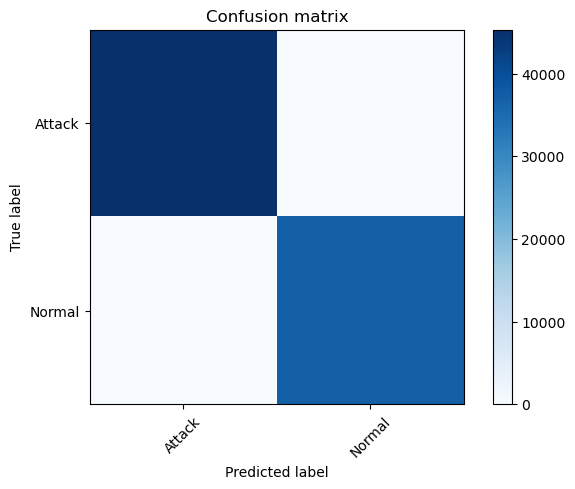

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [54]:
cnn.load_weights('dnn/best_weights_cnn_tanhdadam.hdf5')

pred = cnn.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(cnn_y_true, pred)
print('Accuracy: {}'.format(score))

cnn_cm = confusion_matrix(cnn_y_true, pred)

plt.figure()
plot_confusion_matrix(cnn_cm, attack_cat2)
plt.show()
print(classification_report(cnn_y_true,pred))

#### **CNN RELU SGD MODEL**

In [55]:
checkpointer_cnn = ModelCheckpoint(filepath="dnn/best_weights_cnn_relusgd.hdf5", verbose=1, save_best_only=True)
cnn = Sequential()
cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 199, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

cnn.compile(loss="categorical_crossentropy", optimizer="sgd")

cnn.fit(cnn_x_train, y_train,     
          batch_size=batch_size,
          epochs=1000,
          verbose=1,
          validation_data=(cnn_x_test, y_test),
          callbacks=[monitor, checkpointer_cnn]
         )

Epoch 1/1000
5474/5479 [============================>.] - ETA: 0s - loss: 0.0486
Epoch 1: val_loss improved from inf to 0.00066, saving model to dnn\best_weights_cnn_relusgd.hdf5
5479/5479 [==============================] - 26s 5ms/step - loss: 0.0486 - val_loss: 6.6479e-04
Epoch 2/1000
5475/5479 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 2: val_loss did not improve from 0.00066
5479/5479 [==============================] - 21s 4ms/step - loss: 0.0041 - val_loss: 7.5056e-04
Epoch 3/1000
5474/5479 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 3: val_loss improved from 0.00066 to 0.00021, saving model to dnn\best_weights_cnn_relusgd.hdf5
5479/5479 [==============================] - 22s 4ms/step - loss: 0.0020 - val_loss: 2.1339e-04
Epoch 3: early stopping


2573/2573 [==============================] - 3s 1ms/step
Accuracy: 0.9999635599499557


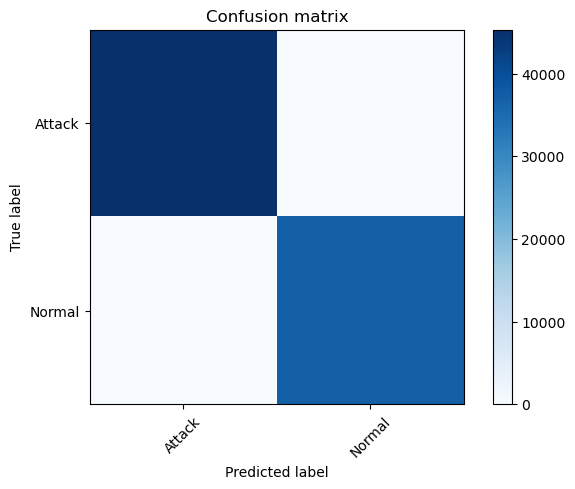

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [56]:
cnn.load_weights('dnn/best_weights_cnn_relusgd.hdf5')

pred = cnn.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(cnn_y_true, pred)
print('Accuracy: {}'.format(score))

cnn_cm = confusion_matrix(cnn_y_true, pred)

plt.figure()
plot_confusion_matrix(cnn_cm, attack_cat2)
plt.show()
print(classification_report(cnn_y_true,pred))

#### **CNN SIGMOID SDG MODEL**

In [57]:
checkpointer_cnn = ModelCheckpoint(filepath="dnn/best_weights_cnn_sigmoidsgd.hdf5", verbose=1, save_best_only=True)
cnn = Sequential()
cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1),
                 activation='sigmoid',
                 input_shape=(1, 199, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                 activation='sigmoid'))
cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation="sigmoid"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

cnn.compile(loss="categorical_crossentropy", optimizer="sgd")

cnn.fit(cnn_x_train, y_train,     
          batch_size=batch_size,
          epochs=1000,
          verbose=1,
          validation_data=(cnn_x_test, y_test),
          callbacks=[monitor, checkpointer_cnn]
         )

Epoch 1/1000
5477/5479 [============================>.] - ETA: 0s - loss: 0.6313
Epoch 1: val_loss improved from inf to 0.71817, saving model to dnn\best_weights_cnn_sigmoidsgd.hdf5
5479/5479 [==============================] - 21s 4ms/step - loss: 0.6313 - val_loss: 0.7182
Epoch 2/1000
5464/5479 [============================>.] - ETA: 0s - loss: 0.6268
Epoch 2: val_loss did not improve from 0.71817
5479/5479 [==============================] - 21s 4ms/step - loss: 0.6268 - val_loss: 0.7222
Epoch 3/1000
5465/5479 [============================>.] - ETA: 0s - loss: 0.6264
Epoch 3: val_loss did not improve from 0.71817
5479/5479 [==============================] - 21s 4ms/step - loss: 0.6264 - val_loss: 0.7192
Epoch 3: early stopping


2573/2573 [==============================] - 3s 1ms/step
Accuracy: 0.5505970094865597


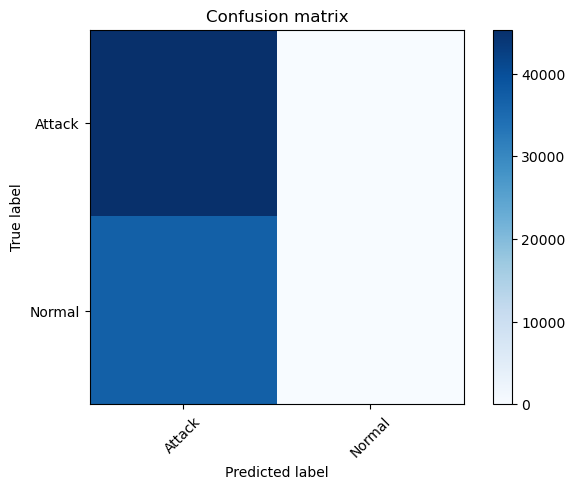

              precision    recall  f1-score   support

           0       0.55      1.00      0.71     45329
           1       0.00      0.00      0.00     36998

    accuracy                           0.55     82327
   macro avg       0.28      0.50      0.36     82327
weighted avg       0.30      0.55      0.39     82327



In [58]:
cnn.load_weights('dnn/best_weights_cnn_sigmoidsgd.hdf5')

pred = cnn.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(cnn_y_true, pred)
print('Accuracy: {}'.format(score))

cnn_cm = confusion_matrix(cnn_y_true, pred)

plt.figure()
plot_confusion_matrix(cnn_cm, attack_cat2)
plt.show()
print(classification_report(cnn_y_true,pred))

#### **CNN TANH SGD MODEL**

In [59]:
checkpointer_cnn = ModelCheckpoint(filepath="dnn/best_weights_cnn_tahnsgd.hdf5", verbose=1, save_best_only=True)
cnn = Sequential()
cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, 199, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                 activation='tanh'))
cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation="tanh"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

cnn.compile(loss="categorical_crossentropy", optimizer="sgd")

cnn.fit(cnn_x_train, y_train,     
          batch_size=batch_size,
          epochs=1000,
          verbose=1,
          validation_data=(cnn_x_test, y_test),
          callbacks=[monitor, checkpointer_cnn]
         )

Epoch 1/1000
5472/5479 [============================>.] - ETA: 0s - loss: 0.0303
Epoch 1: val_loss improved from inf to 0.00207, saving model to dnn\best_weights_cnn_tahnsgd.hdf5
5479/5479 [==============================] - 21s 4ms/step - loss: 0.0302 - val_loss: 0.0021
Epoch 2/1000
5478/5479 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 2: val_loss improved from 0.00207 to 0.00075, saving model to dnn\best_weights_cnn_tahnsgd.hdf5
5479/5479 [==============================] - 22s 4ms/step - loss: 0.0011 - val_loss: 7.5252e-04
Epoch 3/1000
5472/5479 [============================>.] - ETA: 0s - loss: 5.3960e-04
Epoch 3: val_loss improved from 0.00075 to 0.00037, saving model to dnn\best_weights_cnn_tahnsgd.hdf5
5479/5479 [==============================] - 21s 4ms/step - loss: 5.3941e-04 - val_loss: 3.7034e-04
Epoch 4/1000
5460/5479 [============================>.] - ETA: 0s - loss: 3.6253e-04
Epoch 4: val_loss improved from 0.00037 to 0.00025, saving model to dnn\best_w

2573/2573 [==============================] - 3s 1ms/step
Accuracy: 0.9999878533166519


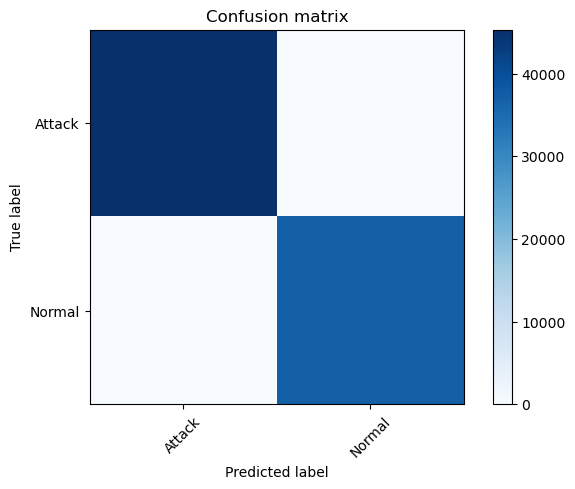

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45329
           1       1.00      1.00      1.00     36998

    accuracy                           1.00     82327
   macro avg       1.00      1.00      1.00     82327
weighted avg       1.00      1.00      1.00     82327



In [60]:
cnn.load_weights('dnn/best_weights_cnn_tahnsgd.hdf5')

pred = cnn.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(cnn_y_true, pred)
print('Accuracy: {}'.format(score))

cnn_cm = confusion_matrix(cnn_y_true, pred)

plt.figure()
plot_confusion_matrix(cnn_cm, attack_cat2)
plt.show()
print(classification_report(cnn_y_true,pred))

#### **ADDITIONAL FEATURES # 1 Multi-Classification**

In [61]:
add_one_train_df = filtered_train_df
add_one_test_df = filtered_test_df

In [62]:
add_one_test_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [63]:
for i in range(len(remove_cols)):
    encode_numeric_zscore(add_one_train_df, remove_cols[i])
    encode_numeric_zscore(add_one_test_df, remove_cols[i])

cols_temp = ['proto', 'state', 'service']

for i in range(len(cols_temp)):
    encode_text_dummy(add_one_train_df, cols_temp[i])
    encode_text_dummy(add_one_test_df, cols_temp[i])
    


In [64]:
add_one_train_df.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,service-ftp,service-ftp-data,service-http,service-irc,service-pop3,service-radius,service-smtp,service-snmp,service-ssh,service-ssl
0,1,-0.191039,-0.104463,-0.135778,-0.049135,-0.102730,-0.576360,0.703779,1.577996,-0.389870,...,0,0,0,0,0,0,0,0,0,0
1,2,-0.109499,-0.046023,0.172575,-0.046412,0.188526,-0.576334,-1.141964,1.559898,-0.389901,...,0,0,0,0,0,0,0,0,0,0
2,3,0.040678,-0.089853,-0.026948,-0.048529,-0.012142,-0.576722,-1.141964,1.559898,-0.389937,...,0,0,0,0,0,0,0,0,0,0
3,4,0.049707,-0.060633,-0.063224,-0.047018,-0.098568,-0.576725,-1.141964,1.559898,-0.389931,...,1,0,0,0,0,0,0,0,0,0
4,5,-0.140430,-0.075243,-0.117640,-0.047556,-0.102062,-0.576606,0.723208,1.559898,-0.389900,...,0,0,0,0,0,0,0,0,0,0


In [65]:
add_one_train_df.shape

(175325, 191)

In [66]:
add_one_train_df = add_one_train_df.drop('id', axis=1)
add_one_test_df = add_one_test_df.drop('id', axis=1)

add_two_train_df = add_one_train_df.copy()
add_two_test_df = add_one_test_df.copy()

In [67]:
add_two_train_df.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service-ftp,service-ftp-data,service-http,service-irc,service-pop3,service-radius,service-smtp,service-snmp,service-ssh,service-ssl
0,-0.191039,-0.104463,-0.135778,-0.049135,-0.102730,-0.576360,0.703779,1.577996,-0.389870,-0.273713,...,0,0,0,0,0,0,0,0,0,0
1,-0.109499,-0.046023,0.172575,-0.046412,0.188526,-0.576334,-1.141964,1.559898,-0.389901,-0.069255,...,0,0,0,0,0,0,0,0,0,0
2,0.040678,-0.089853,-0.026948,-0.048529,-0.012142,-0.576722,-1.141964,1.559898,-0.389937,-0.252058,...,0,0,0,0,0,0,0,0,0,0
3,0.049707,-0.060633,-0.063224,-0.047018,-0.098568,-0.576725,-1.141964,1.559898,-0.389931,-0.275834,...,1,0,0,0,0,0,0,0,0,0
4,-0.140430,-0.075243,-0.117640,-0.047556,-0.102062,-0.576606,0.723208,1.559898,-0.389900,-0.275574,...,0,0,0,0,0,0,0,0,0,0


In [68]:
add_one_train_df.shape

(175325, 190)

In [69]:
attack_cat1 = encode_text_index(add_one_train_df, 'attack_cat')
attack_cat2 = encode_text_index(add_one_test_df, 'attack_cat')
x_train, y_train = to_xy(add_one_train_df,'attack_cat')
x_test, y_test = to_xy(add_one_test_df,'attack_cat')

#### **Fully-Connected Neural Networks Model Multi-Classification**

In [70]:
num_classes = 10
cnn_x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], 1))
cnn_x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], 1))
num_features=x_train.shape[1]
cnn_y_true = np.argmax(y_test,axis=1)
cnn_scores = []
batch_size = 32

In [71]:
neuron_count = x_train.shape[1]
div = 3
print(neuron_count)

result_values_multiclass = [

]

189


In [72]:
for i in range(len(combinations)):
    model_comp = combinations[i]
    print(model_comp)
    checkpointer = ModelCheckpoint(filepath=checkpoints[model_comp], verbose=0, save_best_only=True)
    print(checkpoints[model_comp])
    model = Sequential()
    for j in range(1):
        
        model.add(Dense(neuron_count, input_dim=x_train.shape[1],activation=model_comp[0]))
        model.add(Dense(neuron_count/div, activation=model_comp[0]))
        model.add(Dense(neuron_count/(div*2), activation=model_comp[0]))
        model.add(Dense(y_train.shape[1], activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))
        
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
        model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=1,epochs=1000)
    model.load_weights(checkpoints[model_comp])
    pred = model.predict(x_test)
    pred = np.argmax(pred,axis=1)
    
    y_true = np.argmax(y_test,axis=1)
    score = metrics.accuracy_score(y_true,pred)
    cm = confusion_matrix(y_true, pred)
    
    result = (model_comp, pred, y_true, score, cm)
    
    result_values_multiclass.append(result)

('relu', 'adam')
dnn/best_weights_fnn_rluadam.hdf5
Epoch 1/1000
5479/5479 [==============================] - 17s 3ms/step - loss: 0.4610 - val_loss: 0.3328
Epoch 2/1000
5479/5479 [==============================] - 17s 3ms/step - loss: 0.4003 - val_loss: 0.3711
Epoch 3/1000
5479/5479 [==============================] - 17s 3ms/step - loss: 0.3852 - val_loss: 0.3370
Epoch 3: early stopping
2573/2573 [==============================] - 3s 1ms/step
('sigmoid', 'adam')
dnn/best_weights_fnn_sigadam.hdf5
Epoch 1/1000
5479/5479 [==============================] - 20s 4ms/step - loss: 0.5746 - val_loss: 0.3584
Epoch 2/1000
5479/5479 [==============================] - 19s 3ms/step - loss: 0.4366 - val_loss: 0.3561
Epoch 3/1000
5479/5479 [==============================] - 18s 3ms/step - loss: 0.4158 - val_loss: 0.3377
Epoch 4/1000
5479/5479 [==============================] - 20s 4ms/step - loss: 0.4017 - val_loss: 0.3333
Epoch 5/1000
5479/5479 [==============================] - 18s 3ms/step - loss: 

In [73]:
relu_adam = result_values_multiclass[0]
sigmoid_adam = result_values_multiclass[1]
tahn_adam = result_values_multiclass[2]
relu_sgd =  result_values_multiclass[3]
sigmoid_sgd = result_values_multiclass[4]
tahm_sgd =  result_values_multiclass[5]

FNN_scores = [relu_adam[3], sigmoid_adam[3], tahn_adam[3], relu_sgd[3], sigmoid_sgd[3], tahm_sgd[3]]
max_score = max(FNN_scores)
max_score_index = FNN_scores.index(max_score)


In [74]:
print(max_score)
print(max_score_index)


0.8837562403585701
3


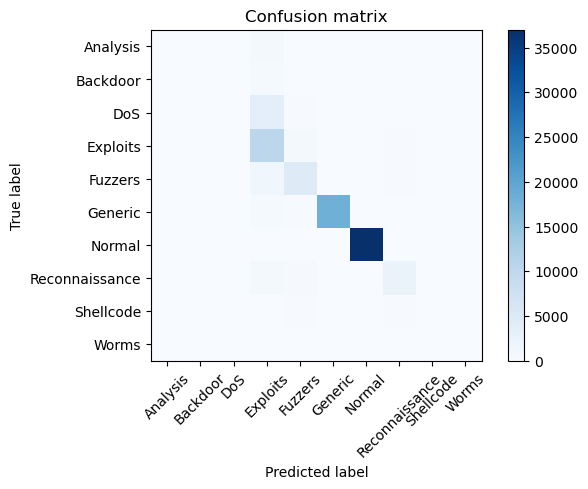

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.00      0.00      0.00       583
           2       0.55      0.01      0.03      4089
           3       0.57      0.92      0.71     11131
           4       0.74      0.74      0.74      6061
           5       1.00      0.96      0.98     18871
           6       1.00      1.00      1.00     36998
           7       0.79      0.67      0.73      3495
           8       0.83      0.08      0.14       378
           9       0.00      0.00      0.00        44

    accuracy                           0.88     82327
   macro avg       0.55      0.44      0.43     82327
weighted avg       0.87      0.88      0.86     82327



In [75]:
relu_adam_pred = relu_adam[1]
relu_adam_y_true = relu_adam[2]
relu_adam_score = relu_adam[3]
relu_adam_cm = relu_adam[4]
plt.figure()
plot_confusion_matrix(relu_adam_cm, attack_cat2)
plt.show()
print(classification_report(relu_adam_y_true,relu_adam_pred))

In [76]:
checkpointer_cnn = ModelCheckpoint(filepath="dnn/best_weights_cnn_reluadam_additional.hdf5", verbose=1, save_best_only=True)
cnn = Sequential()
cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 189, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation="softmax"))

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

cnn.fit(cnn_x_train, y_train,     
          batch_size=batch_size,
          epochs=1000,
          verbose=1,
          validation_data=(cnn_x_test, y_test),
          callbacks=[monitor, checkpointer_cnn]
         )

Epoch 1/1000
5479/5479 [==============================] - ETA: 0s - loss: 0.5379
Epoch 1: val_loss improved from inf to 0.35410, saving model to dnn\best_weights_cnn_reluadam_additional.hdf5
5479/5479 [==============================] - 22s 4ms/step - loss: 0.5379 - val_loss: 0.3541
Epoch 2/1000
5476/5479 [============================>.] - ETA: 0s - loss: 0.4588
Epoch 2: val_loss improved from 0.35410 to 0.34907, saving model to dnn\best_weights_cnn_reluadam_additional.hdf5
5479/5479 [==============================] - 23s 4ms/step - loss: 0.4588 - val_loss: 0.3491
Epoch 3/1000
5467/5479 [============================>.] - ETA: 0s - loss: 0.4392
Epoch 3: val_loss improved from 0.34907 to 0.33862, saving model to dnn\best_weights_cnn_reluadam_additional.hdf5
5479/5479 [==============================] - 23s 4ms/step - loss: 0.4392 - val_loss: 0.3386
Epoch 4/1000
5468/5479 [============================>.] - ETA: 0s - loss: 0.4283
Epoch 4: val_loss did not improve from 0.33862
5479/5479 [====

2573/2573 [==============================] - 4s 1ms/step
Accuracy: 0.878314526218616


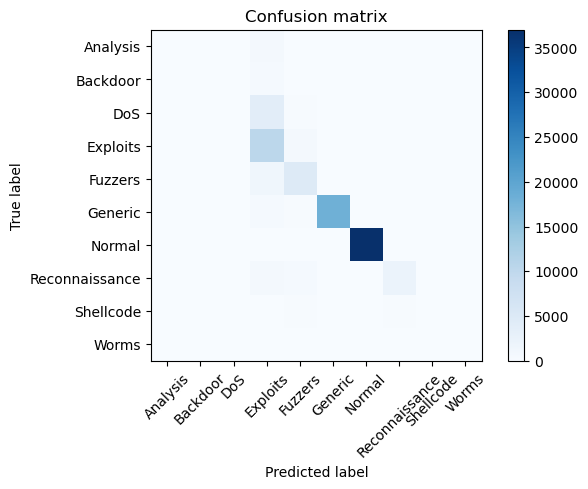

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.00      0.00      0.00       583
           2       0.00      0.00      0.00      4089
           3       0.57      0.93      0.71     11131
           4       0.73      0.76      0.75      6061
           5       1.00      0.96      0.98     18871
           6       1.00      1.00      1.00     36998
           7       0.84      0.62      0.72      3495
           8       1.00      0.00      0.01       378
           9       0.00      0.00      0.00        44

    accuracy                           0.88     82327
   macro avg       0.51      0.43      0.42     82327
weighted avg       0.85      0.88      0.85     82327



In [77]:
cnn.load_weights('dnn/best_weights_cnn_reluadam_additional.hdf5')

pred = cnn.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(cnn_y_true, pred)
print('Accuracy: {}'.format(score))

cnn_cm = confusion_matrix(cnn_y_true, pred)
cnn_scores.append( ('reluadam', score))
plt.figure()
plot_confusion_matrix(cnn_cm, attack_cat2)
plt.show()
print(classification_report(cnn_y_true,pred))

#### **ADDITIONAL Features #2 Oversampling**

In [78]:
train_excel = pd.read_csv('UNSW_NB15_training-set.csv')
test_excel = pd.read_csv('UNSW_NB15_test-set.csv')

train_us_df = train_excel
test_us_df = test_excel

#train_us, test_us = preProcess(train_us_df, test_us_df)

train_us = add_two_train_df.copy()   
test_us = add_two_test_df.copy()

print(train_us.shape)
print(test_us.shape)

(175325, 190)
(82327, 190)


In [79]:
Worms = train_us['attack_cat'].value_counts()['Worms']
Fuzzers = train_us['attack_cat'].value_counts().get('Fuzzers')
Analysis = train_us['attack_cat'].value_counts().get('Analysis')
Backdoors = train_us['attack_cat'].value_counts().get('Backdoor')
Dos = train_us['attack_cat'].value_counts().get('DoS')
Exploits = train_us['attack_cat'].value_counts().get('Exploits')
Generic = train_us['attack_cat'].value_counts().get('Generic')
Shellcode = train_us['attack_cat'].value_counts().get('Shellcode')
Recon = train_us['attack_cat'].value_counts().get('Reconnaissance')

print("Worms: ", Worms)
print("Fuzzers: ", Fuzzers)
print("Fuzzers:", Fuzzers)
print("Analysis:", Analysis)
print("Backdoors:", Backdoors)
print("DoS:", Dos)
print("Exploits:", Exploits)
print("Generic:", Generic)
print("Shellcode:", Shellcode)
print("Reconnaissance:", Recon)

Worms:  130
Fuzzers:  18184
Fuzzers: 18184
Analysis: 2000
Backdoors: 1746
DoS: 12264
Exploits: 33393
Generic: 40000
Shellcode: 1133
Reconnaissance: 10491


In [80]:
worm_num = train_us['attack_cat'].value_counts()['Worms']
worms_needed = 20000 - worm_num;
if worms_needed> 0:
    worm_rows = train_us[train_us['attack_cat'] == 'Worms']
    duplicated_worms = pd.concat([worm_rows] * (worms_needed // worm_num), ignore_index=True)
    train_us = pd.concat([train_us, duplicated_worms], ignore_index=True)

result1 = train_us['attack_cat'].value_counts().get('Worms', 0)
print("Final count of 'Worms':", result1)

#####################################################################

analysis_num = train_us['attack_cat'].value_counts()['Analysis']
analysis_needed = 20000 - analysis_num;
if analysis_needed> 0:
    analysis_rows = train_us[train_us['attack_cat'] == 'Analysis']
    duplicated_analysis = pd.concat([analysis_rows] * (analysis_needed // analysis_num), ignore_index=True)
    train_us = pd.concat([train_us, duplicated_analysis], ignore_index=True)

result2 = train_us['attack_cat'].value_counts().get('Analysis', 0)
print("Final count of 'Analysis':", result2)

#####################################################################

shellcode_num = train_us['attack_cat'].value_counts()['Shellcode']
shellcode_needed = 20000 - shellcode_num;
if shellcode_needed> 0:
    shellcode_rows = train_us[train_us['attack_cat'] == 'Shellcode']
    duplicated_shellcode = pd.concat([shellcode_rows] * (shellcode_needed // shellcode_num), ignore_index=True)
    train_us = pd.concat([train_us, duplicated_shellcode], ignore_index=True)

result3 = train_us['attack_cat'].value_counts().get('Shellcode', 0)
print("Final count of 'Shellcode':", result3)

#train_us.to_csv('oversample_worms_train.csv', sep=',',index=None)

Final count of 'Worms': 19890
Final count of 'Analysis': 20000
Final count of 'Shellcode': 19261


In [81]:

#train_us.to_csv('oversample_worms_train.csv', sep=',',index=None)

In [82]:
worm_num = test_us['attack_cat'].value_counts()['Worms']
worms_needed = 20000 - worm_num;
if worms_needed> 0:
    worm_rows = test_us[test_us['attack_cat'] == 'Worms']
    duplicated_worms = pd.concat([worm_rows] * (worms_needed // worm_num), ignore_index=True)
    test_us = pd.concat([test_us, duplicated_worms], ignore_index=True)

result1 = test_us['attack_cat'].value_counts().get('Worms', 0)
print("Final count of 'Worms':", result1)

#####################################################################

analysis_num = test_us['attack_cat'].value_counts()['Analysis']
analysis_needed = 20000 - analysis_num;
if analysis_needed> 0:
    analysis_rows = test_us[test_us['attack_cat'] == 'Analysis']
    duplicated_analysis = pd.concat([analysis_rows] * (analysis_needed // analysis_num), ignore_index=True)
    test_us = pd.concat([test_us, duplicated_analysis], ignore_index=True)

result2 = test_us['attack_cat'].value_counts().get('Analysis', 0)
print("Final count of 'Analysis':", result2)

#####################################################################

shellcode_num = test_us['attack_cat'].value_counts()['Shellcode']
shellcode_needed = 20000 - shellcode_num;
if shellcode_needed> 0:
    shellcode_rows = test_us[test_us['attack_cat'] == 'Shellcode']
    duplicated_shellcode = pd.concat([shellcode_rows] * (shellcode_needed // shellcode_num), ignore_index=True)
    test_us = pd.concat([test_us, duplicated_shellcode], ignore_index=True)

result3 = test_us['attack_cat'].value_counts().get('Shellcode', 0)
print("Final count of 'Shellcode':", result3)

#train_us.to_csv('oversample_worms_train.csv', sep=',',index=None)

Final count of 'Worms': 19976
Final count of 'Analysis': 19633
Final count of 'Shellcode': 19656


In [83]:
attack_two_cat1= encode_text_index(train_us, 'attack_cat')
attack_two_cat2= encode_text_index(test_us, 'attack_cat')

x_train_two, y_train_two = to_xy(train_us,'attack_cat')
x_test_two, y_test_two = to_xy(test_us,'attack_cat')

In [84]:
add_y_true = np.argmax(y_test_two,axis=1)

In [85]:
# add_one_train_df.to_csv('adonas.csv', sep=',', index=None)
x_train_two.shape

(231213, 189)

In [86]:
# train_us.to_csv('train_us.csv', sep=',', index=None)

Epoch 1/1000
5462/5479 [============================>.] - ETA: 0s - loss: 0.4622
Epoch 1: val_loss improved from inf to 1.61415, saving model to dnn\best_weights_cnn_reluadam_additional2.hdf5
5479/5479 [==============================] - 22s 4ms/step - loss: 0.4621 - val_loss: 1.6142
Epoch 2/1000
5478/5479 [============================>.] - ETA: 0s - loss: 0.4009
Epoch 2: val_loss did not improve from 1.61415
5479/5479 [==============================] - 24s 4ms/step - loss: 0.4009 - val_loss: 1.6423
Epoch 3/1000
5475/5479 [============================>.] - ETA: 0s - loss: 0.3863
Epoch 3: val_loss improved from 1.61415 to 1.55367, saving model to dnn\best_weights_cnn_reluadam_additional2.hdf5
5479/5479 [==============================] - 22s 4ms/step - loss: 0.3863 - val_loss: 1.5537
Epoch 4/1000
5472/5479 [============================>.] - ETA: 0s - loss: 0.3782
Epoch 4: val_loss did not improve from 1.55367
5479/5479 [==============================] - 22s 4ms/step - loss: 0.3782 - val_l

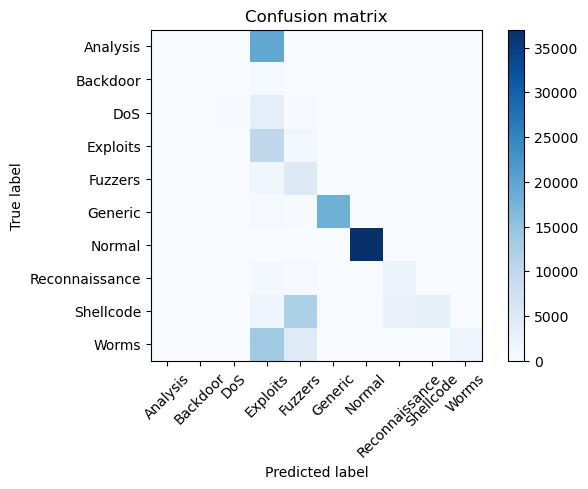

              precision    recall  f1-score   support

           0       0.40      0.00      0.00     19633
           1       0.08      0.00      0.00       583
           2       0.46      0.04      0.07      4089
           3       0.19      0.90      0.32     11131
           4       0.20      0.77      0.32      6061
           5       1.00      0.96      0.98     18871
           6       1.00      1.00      1.00     36998
           7       0.46      0.65      0.54      3495
           8       1.00      0.16      0.27     19656
           9       1.00      0.09      0.17     19976

    accuracy                           0.55    140493
   macro avg       0.58      0.46      0.37    140493
weighted avg       0.78      0.55      0.51    140493



In [87]:
checkpointer_cnn = ModelCheckpoint(filepath='dnn/best_weights_cnn_reluadam_additional2.hdf5', verbose=1, save_best_only=True)

model = Sequential()
for j in range(1):

    model.add(Dense(189, input_dim=x_train_two.shape[1],activation='relu'))
    model.add(Dense(neuron_count/div, activation='relu'))
    model.add(Dense(neuron_count/(div*2), activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test_two,y_test_two),callbacks=[monitor,checkpointer_cnn],verbose=1,epochs=1000)
model.load_weights('dnn/best_weights_cnn_reluadam_additional2.hdf5')
pred = model.predict(x_test_two)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test_two,axis=1)
score = metrics.accuracy_score(add_y_true,pred)
print('Accuracy: {}'.format(score))

add2a_cnn = confusion_matrix(add_y_true, pred)

plt.figure()
plot_confusion_matrix(add2a_cnn, attack_two_cat2)
plt.show()
print(classification_report(add_y_true,pred))


In [88]:
cnn_x_train = x_train_two.reshape((x_train_two.shape[0], 1, x_train_two.shape[1], 1))
cnn_x_test = x_test_two.reshape((x_test_two.shape[0], 1, x_test_two.shape[1], 1))
cnn_y_true = np.argmax(y_test_two,axis=1)

In [89]:
checkpointer_cnn = ModelCheckpoint(filepath="dnn/best_weights_cnn_reluadam_additional_add2a.hdf5", verbose=1, save_best_only=True)
cnn = Sequential()
cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1), activation='relu', input_shape=(1, 189, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(10, activation="softmax"))

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

cnn.fit(cnn_x_train, y_train_two, batch_size=batch_size, epochs=1000, verbose=1, validation_data=(cnn_x_test, y_test_two), callbacks=[monitor, checkpointer_cnn])

Epoch 1/1000
7226/7226 [==============================] - ETA: 0s - loss: 0.6790
Epoch 1: val_loss improved from inf to 0.72904, saving model to dnn\best_weights_cnn_reluadam_additional_add2a.hdf5
7226/7226 [==============================] - 31s 4ms/step - loss: 0.6790 - val_loss: 0.7290
Epoch 2/1000
7221/7226 [============================>.] - ETA: 0s - loss: 0.5524
Epoch 2: val_loss improved from 0.72904 to 0.72670, saving model to dnn\best_weights_cnn_reluadam_additional_add2a.hdf5
7226/7226 [==============================] - 33s 5ms/step - loss: 0.5523 - val_loss: 0.7267
Epoch 3/1000
7224/7226 [============================>.] - ETA: 0s - loss: 0.5183
Epoch 3: val_loss did not improve from 0.72670
7226/7226 [==============================] - 33s 5ms/step - loss: 0.5183 - val_loss: 0.8490
Epoch 4/1000
7222/7226 [============================>.] - ETA: 0s - loss: 0.4988
Epoch 4: val_loss did not improve from 0.72670
7226/7226 [==============================] - 34s 5ms/step - loss: 0.49

4391/4391 [==============================] - 5s 1ms/step
Accuracy: 0.8016983052536425


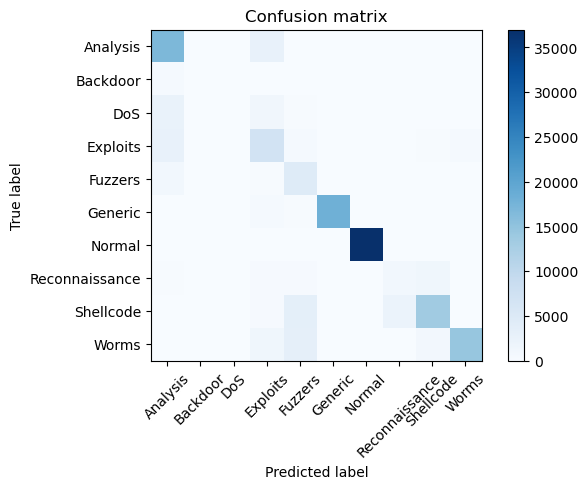

              precision    recall  f1-score   support

           0       0.70      0.86      0.77     19633
           1       0.00      0.00      0.00       583
           2       0.05      0.00      0.00      4089
           3       0.50      0.62      0.56     11131
           4       0.37      0.75      0.50      6061
           5       1.00      0.96      0.98     18871
           6       1.00      1.00      1.00     36998
           7       0.31      0.31      0.31      3495
           8       0.84      0.69      0.76     19656
           9       0.95      0.73      0.82     19976

    accuracy                           0.80    140493
   macro avg       0.57      0.59      0.57    140493
weighted avg       0.81      0.80      0.80    140493



In [90]:
cnn.load_weights('dnn/best_weights_cnn_reluadam_additional_add2a.hdf5')

pred = cnn.predict(cnn_x_test)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(cnn_y_true, pred)
print('Accuracy: {}'.format(score))

cnn_cm = confusion_matrix(add_y_true, pred)
cnn_scores.append( ('reluadam', score))
plt.figure()
plot_confusion_matrix(cnn_cm, attack_two_cat2)
plt.show()
print(classification_report(add_y_true,pred))